# Arrow detection using tensorflow

## 1. Load configs

In [3]:
%load_ext autoreload
%autoreload 2

import os
import pickle

files = pickle.load(open('files.pickle', 'rb'))
paths = pickle.load(open('paths.pickle', 'rb'))
paths

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


{'WORKSPACE_PATH': 'Tensorflow/workspace',
 'SCRIPTS_PATH': 'Tensorflow/scripts',
 'APIMODEL_PATH': 'Tensorflow/models',
 'ANNOTATION_PATH': 'Tensorflow/workspace/annotations',
 'IMAGE_PATH': 'Tensorflow/workspace/images',
 'MODEL_PATH': 'Tensorflow/workspace/models',
 'PRETRAINED_MODEL_PATH': 'Tensorflow/workspace/pre-trained-models',
 'CHECKPOINT_PATH': 'Tensorflow/workspace/models/my_ssd_mobnet_640',
 'OUTPUT_PATH': 'Tensorflow/workspace/models/my_ssd_mobnet_640/export',
 'TFJS_PATH': 'Tensorflow/workspace/models/my_ssd_mobnet_640/tfjsexport',
 'TFLITE_PATH': 'Tensorflow/workspace/models/my_ssd_mobnet_640/tfliteexport',
 'PROTOC_PATH': 'Tensorflow/protoc'}

## 2. Load model

In [2]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [22]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-3')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

## 3. Load image and detect

In [3]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt

import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline

In [4]:
def show_detections(detections):
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes'] + label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=10,
                min_score_thresh=.2,
                agnostic_mode=False)

    plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
    #plt.show()

In [7]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])
a=['IMG_20210706_091951.jpg',
'IMG_20210706_093257.jpg',
'IMG_20210713_185245.jpg',
'IMG_20210713_190716.jpg',
'IMG_20210716_184927.jpg',
'IMG_20210716_190302.jpg',
'IMG_20210706_092755.jpg',
'IMG_20210713_183005.jpg',
'IMG_20210713_190253.jpg',
'IMG_20210713_191239.jpg',
'IMG_20210716_185412.jpg',
'IMG_20210716_192912.jpg']
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'test', a[1])
IMAGE_PATH

'Tensorflow/workspace/images/test/IMG_20210706_093257.jpg'

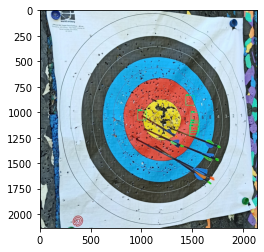

In [32]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

show_detections(detections)

In [30]:
detections

{'detection_boxes': <tf.Tensor: shape=(1, 100, 4), dtype=float32, numpy=
 array([[[0.39328572, 0.6687841 , 0.43666103, 0.7076586 ],
         [0.4702886 , 0.6925065 , 0.5141364 , 0.7313358 ],
         [0.46240306, 0.44833106, 0.50450385, 0.48756957],
         [0.5191058 , 0.68911594, 0.56237614, 0.72806555],
         [0.53278494, 0.68559873, 0.57621205, 0.72431076],
         [0.50912523, 0.6916438 , 0.55194485, 0.7304954 ],
         [0.495573  , 0.6948244 , 0.53960663, 0.733282  ],
         [0.40364447, 0.67231005, 0.4462197 , 0.7123657 ],
         [0.67238593, 0.61553013, 0.71498585, 0.65487444],
         [0.5477361 , 0.68212324, 0.5918916 , 0.7209993 ],
         [0.5584047 , 0.67661166, 0.60066164, 0.71612036],
         [0.52165353, 0.4628543 , 0.56341195, 0.5020182 ],
         [0.35725677, 0.40911546, 0.4002421 , 0.44805047],
         [0.41730905, 0.676143  , 0.46038258, 0.7150013 ],
         [0.46084243, 0.37328708, 0.502906  , 0.41248804],
         [0.48371089, 0.6900213 , 0.523896

## TensorFlow Lite

In [15]:
def set_input_tensor(interpreter, image):
    tensor_index = interpreter.get_input_details()[0]['index']
    input_tensor = interpreter.tensor(tensor_index)()[0]
    input_tensor[:, :] = np.expand_dims((image-255)/255, axis=0)

def get_output_tensor(interpreter, index):
    output_details = interpreter.get_output_details()[index]
    return np.squeeze(interpreter.get_tensor(output_details['index']))

def detect_objects(interpreter, image, threshold):
    set_input_tensor(interpreter, image)
    interpreter.invoke()
    scores = get_output_tensor(interpreter, 0)
    boxes = get_output_tensor(interpreter, 1)
    count = int(get_output_tensor(interpreter, 2))
    classes = get_output_tensor(interpreter, 3)

    results = []
    for i in range(count):
        if scores[i] >= threshold:
            result = {
                'bounding_box': boxes[i],
                'class_id': classes[i],
                'score': scores[i]
            }
            results.append(result)
    return results

In [33]:
import cv2
from tflite_runtime.interpreter import Interpreter
import numpy as np

interpreter = Interpreter('Tensorflow/workspace/models/my_ssd_resnet50/tfliteexport/saved_model/detect.tflite')
interpreter.allocate_tensors()
_, input_height, input_width, _ = interpreter.get_input_details()[0]['shape']

print(input_height, input_width)

img = cv2.resize(cv2.cvtColor(cv2.imread(IMAGE_PATH), cv2.COLOR_BGR2RGB), (input_height, input_width))

#plt.imshow(img)
#img = cv2.resize(cv2.imread(IMAGE_PATH), (input_height, input_width))
#image_np = np.array(img)
#input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)

res = detect_objects(interpreter, img, 0)
for r in res:
    print(r)

640 640
{'bounding_box': array([0.05007999, 0.0389404 , 0.08993416, 0.0779717 ], dtype=float32), 'class_id': 0.0, 'score': 0.00788793}
{'bounding_box': array([0.06255465, 0.03887146, 0.10239088, 0.07793585], dtype=float32), 'class_id': 0.0, 'score': 0.0077307224}
{'bounding_box': array([0.03768516, 0.05110966, 0.07756805, 0.09014225], dtype=float32), 'class_id': 0.0, 'score': 0.0075716972}
{'bounding_box': array([0.0376744 , 0.16350043, 0.07755063, 0.20248756], dtype=float32), 'class_id': 0.0, 'score': 0.0074645877}
{'bounding_box': array([0.03767467, 0.17599846, 0.077551  , 0.2149856 ], dtype=float32), 'class_id': 0.0, 'score': 0.007457435}
{'bounding_box': array([0.03767426, 0.15100363, 0.07754955, 0.1899921 ], dtype=float32), 'class_id': 0.0, 'score': 0.007452488}
{'bounding_box': array([0.03767488, 0.18849954, 0.07755069, 0.2274876 ], dtype=float32), 'class_id': 0.0, 'score': 0.0074377954}
{'bounding_box': array([0.07505572, 0.03888301, 0.11488703, 0.07795539], dtype=float32), 'cla